In [14]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
from numba import jit
import scipy
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

## utils

In [2]:
from nimbl import stations  #.from_mos2ktbl

#selected stations for analysis
station_data = '//scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/common/mdl_station.tbl'
station_points = stations.from_mos2ktbl(station_data, ['KSEA','KMSP','KBOS', 'KLAS','KLIT','KMCO', 'KDEN', 'KCVG'])

#rename weird ones
st_names = station_points['name'].copy()
st_names[3] = 'Las Vegas'
st_names[6] = 'Denver'
st_names[8] = 'Cincinnati'

In [3]:
#get CONUS lat/lons
ds = xr.open_dataset(f'/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/limit_water_v4/blend.supplemental_locations_4.co.2p5.nc',
             mode="r")

#unpack lats and lons to index over
lat_arr = ds.latitude.data
lon_arr = ds.longitude.data
ds.close()

ny, nx = np.shape(lat_arr)

In [4]:
def get_nearest_grid(lat_input, long_input):
    # Get indices of the nearest lat/lon values
    # Lat/long input will be values corresponding to chosen stations
    lat_index, lon_index = [],[]


    for i in range(len(lat_input)):
        a = np.abs(lat_arr-station_lats[i]) + np.abs(lon_arr-station_lons[i])
        i,j = np.unravel_index(a.argmin(), a.shape)
        lat_index.append(i)
        lon_index.append(j)
    return lat_index, lon_index

def to360(x):
    return (x - 180) % 360 + 180

station_lats = station_points['lat']
station_lons = to360(station_points['lon']) #need to convert from E/W to 0-360

lat_idx, lon_idx = get_nearest_grid(station_lats, station_lons)

conus_gp = (lat_idx, lon_idx)

def find_nearest(array,value):
    idx = (np.abs(np.array(array)-value)).argmin()
    return idx

# Diurnal cycle from 3 month window

In [5]:
def open_and_sum(files):
    apcp_sums = np.zeros((len(st_names),len(files)),dtype=np.float32)
    
    #sum given hour for each day/year
    for day in range(len(files)):
        f = files[day]
        ds = Dataset(f, mode='r')
        apcp_var = ds.variables['precipitation']
        apcp = np.asarray(apcp_var[0])
        ds.close()
        apcp_sums[:, day] = apcp[conus_gp[0], conus_gp[1]]
    return apcp_sums

In [6]:
def collect_files(month, domain):
    file_list = []
    for i in range(2002, 2024):
        chosen_date = datetime.datetime(year=i, month=month, day=1)
        #logic for determining prev/next months
        if month == 1:
            prev_month = 12
            prev_year = i-1
            next_month = month+1
            next_year = i
        elif month == 12:
            prev_month = month-1
            prev_year = i
            next_month = 1
            next_year = i+1
        elif (month == 12) and (i == 2023):
            prev_month = month-1
            prev_year = i
            next_month = month
            next_year = i
        elif (month == 1) and (i == 2002):
            prev_month = month
            prev_year = i
            next_month = month+1
            next_year = i
        else:
            prev_month = month-1
            prev_year = i
            next_month = month+1
            next_year = i
    
        #determine which days of year correspond to chosen month
        date_touples = [(prev_month, prev_year), (month, i), (next_month, next_year)]
        for datet in date_touples:
            m, y = datet[0], datet[1]
            dt = datetime.datetime(year=y, month=m, day=1)
            this_doy = dt.strftime('%Y%j')
            start = int(this_doy[4:])
            end = start+pd.Period(f'{y}-{m}-1').daysinmonth-1 #how does datetime not have a # of days in month func??
            path = f"/scratch2/STI/mdl-sti/Sidney.Lower/mswep/mswep_interp/{domain}/{y}/"
            expected_files = [path+f"{y}"+"{:03}.*.nc".format(j) for j in range(start, end+1)]
            for file_ in expected_files:
                file_list.append(sorted(glob(file_)))
    #clean up nested list structure
    mswep_paths = [
        x
        for xs in file_list
        for x in xs
    ]

    mswep_paths = np.unique(mswep_paths)
    #make list of lists to separate files by day
    mswep_files = [mswep_paths[8*i:8*(1+i)] for i in range(int(len(mswep_paths)/8))]
    
    return mswep_files

In [7]:
precip_files = collect_files(7, 'co')

In [8]:
np.shape(precip_files)

(2024, 8)

In [8]:
n_processes = 30

print('Processing files, making daily sums')
start = datetime.datetime.now()
print(f'    Using {n_processes} CPUs')
with multiprocessing.Pool(n_processes) as P:
    out = P.map(open_and_sum, precip_files)
out = np.asarray(out)
end=datetime.datetime.now()
print(f'    Finished in {(end-start).total_seconds()}s')
P.close()

Processing files, making daily sums
    Using 30 CPUs
    Finished in 83.160337s


In [11]:
np.shape(out) #day, station, hour

(2024, 9, 8)

Text(0.0485, 0.1, 'Stacked Precipitation [mm]')

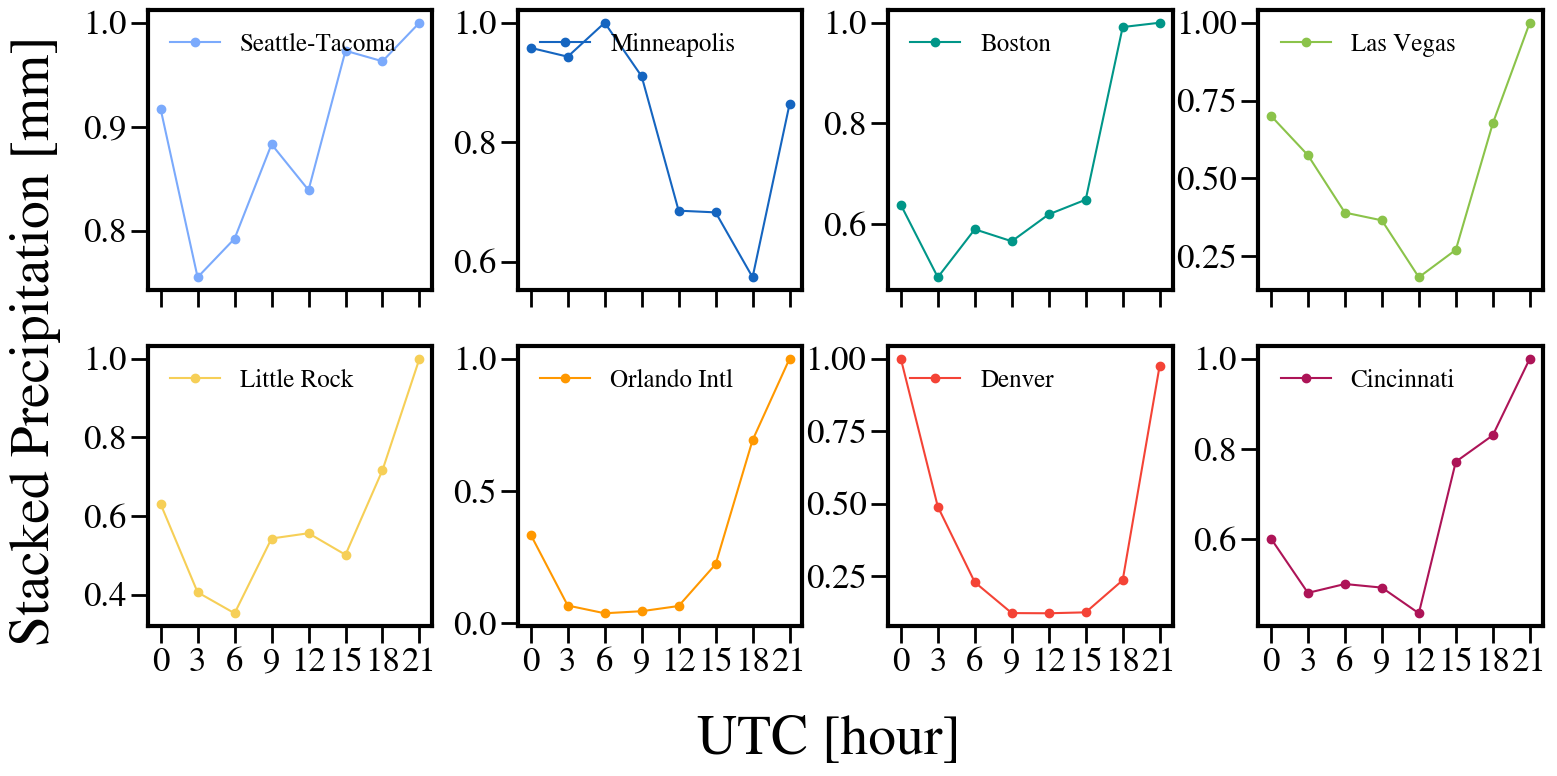

In [17]:
fig, axes = plt.subplots(2,4, sharex=True, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

hours = [0,3, 6, 9, 12, 15, 18, 21]
for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        axes[i,j].plot(hours, np.sum(out[:,stat,:], axis=0)/np.max(np.sum(out[:,stat,:], axis=0)), color=colors[stat], marker='o', label=st_names[stat].title())
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
        axes[i,j].set_xticks(hours)

fig.text(x=0.43, y=-0.05, s='UTC [hour]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.1, s='Stacked Precipitation [mm]', rotation='vertical',fontdict={'fontsize': 40})

## Determining time of peak rainfall over 24 hours

The goal of this analysis is to use the diurnal cycle of precipitation as an additional constraint for the supplemental locations algorithm. The idea is to compare rainfall patterns, measured from 3-hour totals, between the origin point and potential supplemental locations. This will provide additional information that can't be determined from the monthly precipitation distributions alone. 

Below is the prototype for characterizing the diurnal cycle at the stations of interest. I'll use Fourier analysis to decompose the precipitation data into their constituent periodic modes. From FFT, I can back out the most significant components that describe the periodic nature of the rainfall -- primarily the 24 hour cycle but we'll also see some locations that typically have more than 1 significant episode of rainfall a day. The property of interest (among several possible) is *when* the most rain tends to fall during a 24 hour period, which is measured from the phase shifts of the dominant modes of periodicty. 

Of course, this is not the only way to determine when rainfall peaks (an alternative would be to take the average rainfall in each hour from the stacked measurements over the 2002-2023 period, but the accuracy of that average amount seems to me like it would be low) but is one that is pretty commonly used when analyzing diurnal precipitation cycles in the literature.

In [34]:
## Precip data
stat = 5 #which station
print(f'Working on {st_names[stat].title()}')
precip_data = np.ravel(out[:,stat,:]) #unravel list of lists, which contain precip data by day


## Time information
dt = 3 #duration / time intervals of precipitation data
n = len(precip_data)
time = np.arange(n) * dt #hour of each precip measurement, relative to 0z measurement of first day

Working on Orlando Intl


In [35]:
# Perform FFT
fft_result = np.fft.fft(precip_data)

## Sampling frequencies
frequencies = np.fft.fftfreq(n, d=dt)

## Amplitude/strenght of frequencies
amplitude_spectrum = np.abs(fft_result)/np.max(np.abs(fft_result))

Text(0.5, 0, 'Frequency [hour$^{-1}$]')

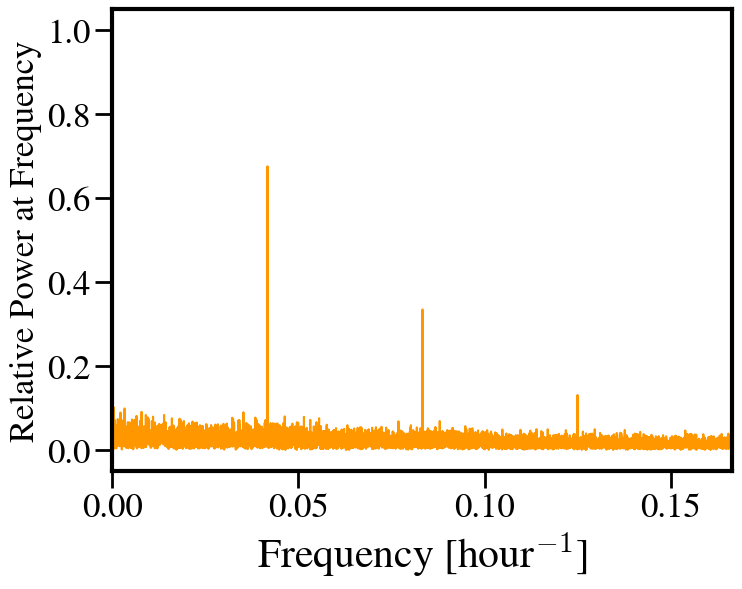

In [36]:
colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

## As a function of frequency

plt.plot(frequencies,amplitude_spectrum,color=colors[stat])
plt.xlim([0.0,np.max(frequencies)]) #cut to ignore 0 frequency and mirror
plt.ylabel('Relative Power at Frequency', fontsize=25)
plt.xlabel('Frequency [hour$^{-1}$]')

Text(0.5, 0, 'Period [hour]')

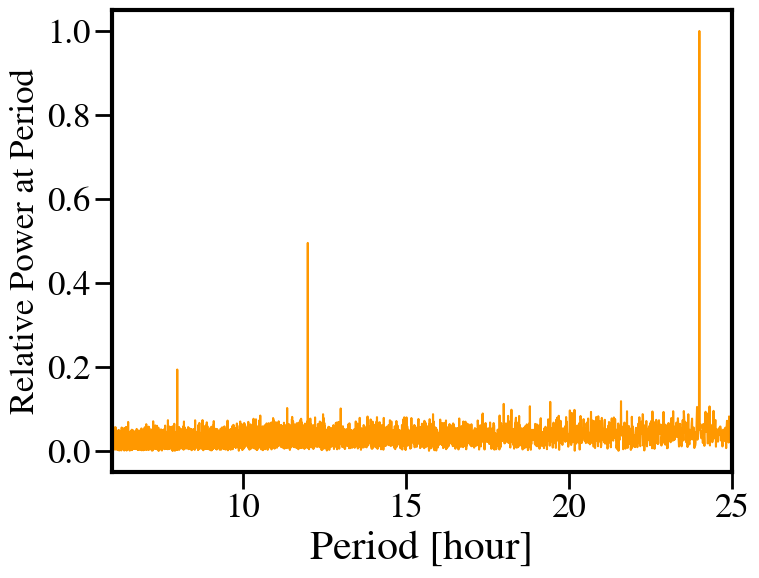

In [37]:
## As a function of time

# isolate frequencies corresponding to periods of < 24 h
time_lims = [2*dt,25.] #can't sample below twice the time resolution of data
freq_lims = [find_nearest(frequencies,1./time_lims[1]), find_nearest(frequencies,1./time_lims[0])]
trange = 1./frequencies[freq_lims[0]:freq_lims[1]]
signal = np.abs(fft_result[freq_lims[0]:freq_lims[1]])/np.max(np.abs(fft_result[freq_lims[0]:freq_lims[1]]))

plt.plot(trange,signal,color=colors[stat])
plt.xlim(time_lims)
#plt.ylim([0,0.1])
plt.ylabel('Relative Power at Period', fontsize=25)
plt.xlabel('Period [hour]')

Text(0.0485, 0.15, 'Relative Power at Period')

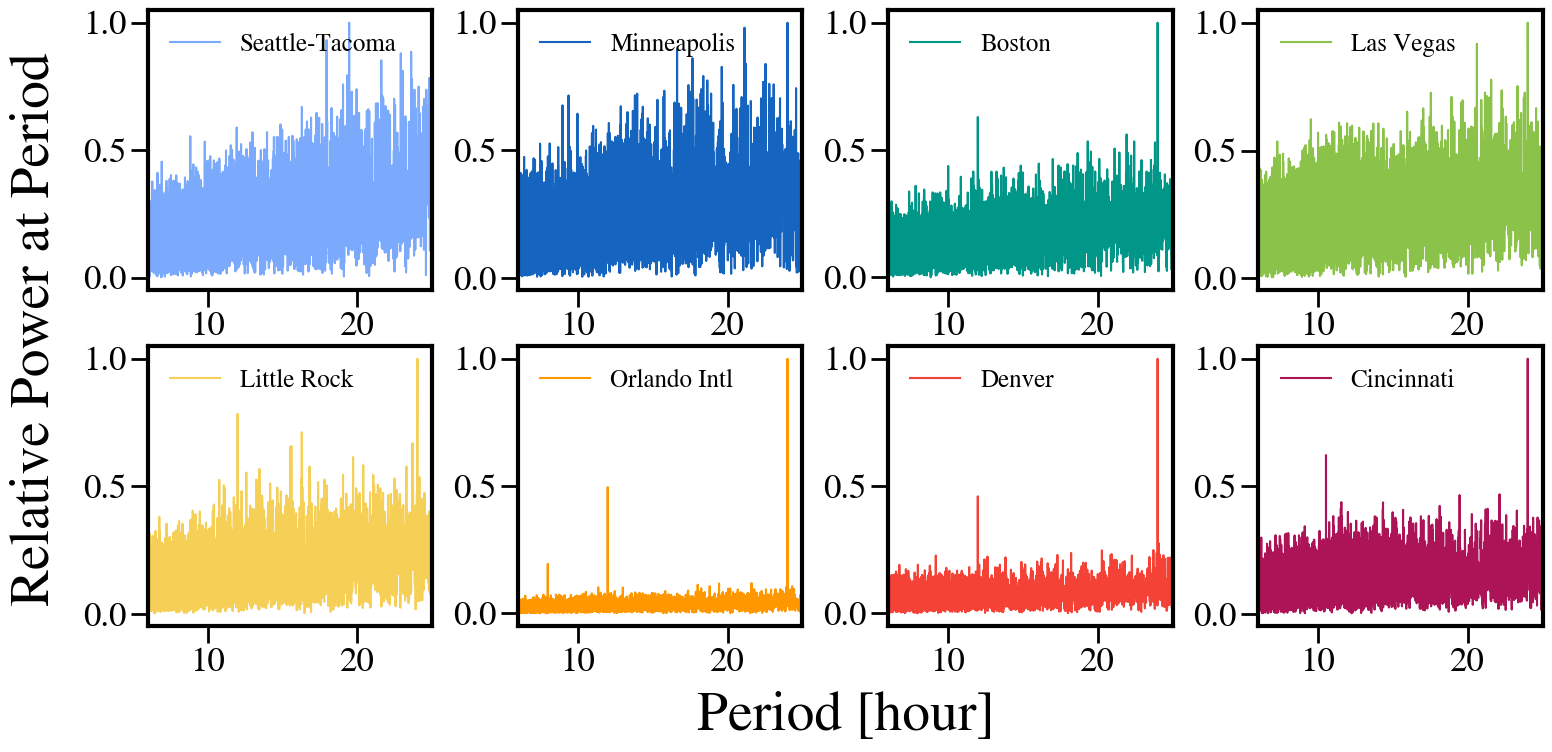

In [67]:
## All together

fig, axes = plt.subplots(2,4, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.2)

colors = ['#7BAAFC',
'#1565c0ff',
'#009688ff',
'#8bc34aff',
'#F6CF57',
'#ff9800ff',
'#f44336ff', 'gray',
'#ad1457ff']

for i in range(2):
    for j in range(4):
        stat = 4*i+j
        if stat == 7:
            stat = 8
        precip_data = np.ravel(out[:,stat,:])

        #FFT
        fft_result = np.fft.fft(precip_data)
        frequencies = np.fft.fftfreq(n, d=dt)
        amplitude_spectrum = np.abs(fft_result)/np.max(np.abs(fft_result))

        #to time
        time_lims = [2*dt,25.] #can't sample below twice the time resolution of data
        freq_lims = [find_nearest(frequencies,1./time_lims[1]), find_nearest(frequencies,1./time_lims[0])]
        trange = 1./frequencies[freq_lims[0]:freq_lims[1]]
        signal = np.abs(fft_result[freq_lims[0]:freq_lims[1]])/np.max(np.abs(fft_result[freq_lims[0]:freq_lims[1]]))
        
        axes[i,j].plot(trange,signal, color=colors[stat],label=st_names[stat].title())
        axes[i,j].legend(frameon=False, fontsize=18, loc='upper left')
        axes[i,j].set_xlim(time_lims)

fig.text(x=0.43, y=-0.02, s='Period [hour]', fontdict={'fontsize': 40})
fig.text(x=0.0485, y=0.15, s='Relative Power at Period', rotation='vertical',fontdict={'fontsize': 40})

In the plot above, we can see that some stations have very strong periodic signals over intervals of ~24 hours or 12 hours -- that's our diurnal cycle! Though some like Seattle or Minneapolis have much noiser signals, meaning there isn't really a dominant mode of periodicity, so rainfall does not tend to fall in a reapting pattern over any period < 24 hours (if we extend to see periods corresponding to 6, 8, and 12 months, there is some signal indicating seasonal patterns in rainfall.)

In any case, we can first examine the mode corresponding to the 24 hour period, determining when this mode tends to peak and how much the typical rainfall is at that time (by stacking and averaging the data at that time over the 2002-2023 period).

In [87]:
# break it down again
dt = 3 #duration / time intervals of precipitation data
n = len(precip_data)
frequencies = np.fft.fftfreq(n, dt)
mswep_hours = np.arange(0,24,3)

for stat in range(len(st_names)):
    if stat == 7:
        continue
    precip_data = np.ravel(out[:,stat,:])
    fft_result = np.fft.fft(precip_data)
    
    # Find the index of the frequency closest to 24 hour period
    target_frequency = 1. / 24.
    idx = find_nearest(frequencies, target_frequency)
    
    # Get the amplitude and phase at this frequency
    amplitude = np.abs(fft_result[idx])
    phase = np.angle(fft_result[idx])
    
    # Calculate the time of peak precipitation within a 24-hour period
    # Phase shift (in hours) = (phase / (2 * pi)) * 24
    time_of_peak = (phase / (2 * np.pi)) * 24

    #if time of peak is negative, just subtract from 24h
    if time_of_peak < 0.:
        time_of_peak = 24 + time_of_peak

    ave = np.mean(out[:,stat,:], axis=0) #take average at each hour over 2002-2023 period
    peak_hour_idx = find_nearest(mswep_hours, time_of_peak)
    ave_peak = ave[peak_hour_idx]
    
    print(f'Daily rainfall in July for {st_names[stat].title()} tends to peak at {time_of_peak:.1f} UTC')
    print(f'                  with an average rainfall max of {ave_peak:.2f}mm over 3 hours.')

Daily rainfall in July for Seattle-Tacoma tends to peak at 5.9 UTC
                  with an average rainfall max of 0.09mm over 3 hours.
Daily rainfall in July for Minneapolis tends to peak at 20.2 UTC
                  with an average rainfall max of 0.42mm over 3 hours.
Daily rainfall in July for Boston tends to peak at 5.0 UTC
                  with an average rainfall max of 0.33mm over 3 hours.
Daily rainfall in July for Las Vegas tends to peak at 1.6 UTC
                  with an average rainfall max of 0.04mm over 3 hours.
Daily rainfall in July for Little Rock tends to peak at 4.4 UTC
                  with an average rainfall max of 0.25mm over 3 hours.
Daily rainfall in July for Orlando Intl tends to peak at 4.0 UTC
                  with an average rainfall max of 0.17mm over 3 hours.
Daily rainfall in July for Denver tends to peak at 0.8 UTC
                  with an average rainfall max of 0.42mm over 3 hours.
Daily rainfall in July for Cincinnati tends to peak at 4.7 UTC

So for locations with precipitation that is not so straighforwardly/cleanly periodic over 24 hours, we can also identify the frequencies/periods where there is significant periodicty.

In [33]:
for stat in range(len(st_names)):
    if stat == 7:
        continue
    precip_data = np.ravel(out[:,stat,:])
    fft_result = np.fft.fft(precip_data)

    #cut data because we only care about daily signals
    time_lims = [2*dt,25.] #can't sample below twice the time resolution of data
    freq_lims = [find_nearest(frequencies,1./time_lims[1]), find_nearest(frequencies,1./time_lims[0])]
    trange = 1./frequencies[freq_lims[0]:freq_lims[1]]
    signal = np.abs(fft_result[freq_lims[0]:freq_lims[1]])/np.max(np.abs(fft_result[freq_lims[0]:freq_lims[1]]))

    # Identify dominant frequencies within the 24-hour cycle
    # PREVIOUSLY: by selecting frequencies within 80% of the primary signal
    # NOW: by separation from "noise" level
    #selected_signals = np.where(signal > 0.8)
    selected_signals = np.where(signal > (np.mean(signal) + 5*np.std(signal)))
    #sort by strength
    signal_at = np.argsort(signal[selected_signals[0]])
    dominant_periods = trange[selected_signals[0]][signal_at]

    print(f"{st_names[stat].title()} has {len(dominant_periods)} dominant signals")
    print(f"corresponding to periods of {np.round(dominant_periods, 1)} hours")
    print(f"from weakest to strongest.\n\n")


Seattle-Tacoma has 5 dominant signals
corresponding to periods of [21.6 22.9 23.6 17.9 19.4] hours
from weakest to strongest.


Minneapolis has 3 dominant signals
corresponding to periods of [16.6 21.1 24. ] hours
from weakest to strongest.


Boston has 3 dominant signals
corresponding to periods of [21.9 12.  24. ] hours
from weakest to strongest.


Las Vegas has 2 dominant signals
corresponding to periods of [20.6 24. ] hours
from weakest to strongest.


Little Rock has 6 dominant signals
corresponding to periods of [15.5 15.6 23.7 16.3 12.  24. ] hours
from weakest to strongest.


Orlando Intl has 3 dominant signals
corresponding to periods of [ 8. 12. 24.] hours
from weakest to strongest.


Denver has 3 dominant signals
corresponding to periods of [24.1 12.  24. ] hours
from weakest to strongest.


Cincinnati has 2 dominant signals
corresponding to periods of [10.5 24. ] hours
from weakest to strongest.


